In [1]:
# INSTALL PACKAGES
# !pip install gpytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.6/175.6 kB 11.8 MB/s eta 0:00:00


In [1]:
# LOAD PACKAGES
import warnings
import torch
from gpytorch.distributions import base_distributions
from gpytorch.functions import log_normal_cdf
from gpytorch.likelihoods.likelihood import _OneDimensionalLikelihood

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy
import gpytorch
import time as time

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Implement BinomialLikelihood
class BinomialLikelihood(_OneDimensionalLikelihood):
    r"""
    Implements the Binomial likelihood for count data y between 1 and m.
    The Binomial distribution is parameterized by :math:`m > 0`.
    We can write the likelihood as:

    .. math::
        \begin{equation*}
            p(Y=y|f,m)=\phi(f)^y(1-\phi(f))^{(m-y)}
        \end{equation*}
    """

# Total number of trials in the Binomial distribution
    def __init__(self, n_trials):
        super().__init__()
        self.n_trials = n_trials

# Calculates CDF of a normal distribution of mean 0 and variance 1 at the 'function samples'
# The CDF values are stored at 'output_probs' and its size is printed
# Finally, it returns the binomial distribution with N trials as the total count,
# and 'output probability' as the probabilities
    def forward(self, function_samples, **kwargs):
        output_probs = base_distributions.Normal(0, 1).cdf(function_samples)
        print(output_probs.size())
        return base_distributions.Binomial(total_count=self.n_trials, probs=output_probs)

# Calculates the log marginal probabilities given the function distribution
    def log_marginal(self, observations, function_dist, *args, **kwargs):
        marginal = self.marginal(function_dist, *args, **kwargs)
        return marginal.log_prob(observations)

# Computes the marginal distribution based on the mean and variance of 'function_dist'
# using some transformations
# It uses CDF of normal distribution to calculate 'output_probs' and returns
# a binomial distribution with 'num_data' as the total count and 'output_probs' as
# probabilities.
    def marginal(self, function_dist, **kwargs):
        mean = function_dist.mean
        var = function_dist.variance
        link = mean.div(torch.sqrt(1 + var))
        output_probs = base_distributions.Normal(0, 1).cdf(link)
        return base_distributions.Binomial(total_count=self.num_data, probs=output_probs)

# Calculates the expected log probability of observation given the function distribution
# It first checks whether any observation is outside the valid range [0, n_trials] and
# issues a warning if they are - then, it clamps the observations to be within the range
    def expected_log_prob(self, observations, function_dist, *params, **kwargs):
        if torch.any(torch.logical_or(observations.le(-1), observations.ge(self.n_trials+1))):
            # Remove after 1.0
            warnings.warn(
                "BinomialLikelihood.expected_log_prob expects observations with labels in [0, m]. "
                "Observations <0 or >m are not allowed.",
                DeprecationWarning,
            )
        else:
            for i in range(observations.size(0)):
                observations[i] = torch.clamp(observations[i],0,self.n_trials[i])

        # Custom function here so we can use log_normal_cdf rather than Normal.cdf
        # This is going to be less prone to overflow errors
        log_prob_lambda = lambda function_samples: self.n_trials*log_normal_cdf(-function_samples) + \
                observations.mul(log_normal_cdf(function_samples)-log_normal_cdf(-function_samples))
        log_prob = self.quadrature(log_prob_lambda, function_dist)
        return log_prob

In [4]:
# implement GP class
class BinomialGPModel(gpytorch.models.ApproximateGP):
    def __init__(self, train_x):
        variational_distribution = CholeskyVariationalDistribution(train_x.size(0))
        variational_strategy = VariationalStrategy(
            self, train_x, variational_distribution, learn_inducing_locations=False
        )
        super(BinomialGPModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.LinearMean(input_size=train_x.size(1))
        # ARD kernel for covariate, geospatial and time confounding
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=train_x.size(1)))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [5]:
# def transform_data(data):
#     n = data.shape[0]
#     x = np.zeros((n,11))
#     y = np.zeros((n,))
#     theta = np.zeros((n,))
#     N = np.zeros((n,))
#     x[:,0] = data["latitude"].to_numpy()
#     x[:,1] = data["longitude"].to_numpy()
#     x[:,2] = (data["gender"].to_numpy()=="Male")
#     x[:,3] = (data["gender"].to_numpy()=="Female")
#     x[:,4] = (data["gender"].to_numpy()=="Non-binary")
#     x[:,5] = (data["race"].to_numpy()=="White")
#     x[:,6] = (data["race"].to_numpy()=="Black")
#     x[:,7] = (data["race"].to_numpy()=="Hispanic")
#     x[:,8] = (data["race"].to_numpy()=="Asian")
#     x[:,9] = (data["race"].to_numpy()=="Other")
#     x[:,10] = data["year"].to_numpy()
#     theta = data["theta"].to_numpy()
#     y = data["Y"].to_numpy()
#     N = data["n"].to_numpy()

#     return torch.from_numpy(x).double(), torch.from_numpy(y).double(),\
#             torch.from_numpy(N).double(), theta

In [6]:
def transform_data(data):
    n = data.shape[0]
    x = np.zeros((n, 6))
    y = np.zeros((n,))
    theta = np.zeros((n,))
    N = np.zeros((n,))

    # Encode gender as binary variables
    x[:,0] = (data["gender"] == "Male")
    x[:,1] = (data["gender"] == "Female")

    # Encode race as binary variables
    x[:,2] = (data["race"] == "White")
    x[:,3] = (data["race"] == "Black")
    x[:,4] = (data["race"] == "Other")

    # Year as a continuous variable
    x[:,5] = data["year"].to_numpy()

    # Target variables
    theta = data["theta"].to_numpy()
    y = data["Y"].to_numpy()
    N = data["n"].to_numpy()
    
    return torch.from_numpy(x).float(), torch.from_numpy(y).float(),\
       torch.from_numpy(N).float(), torch.from_numpy(theta).float()

#     return torch.from_numpy(x).double(), torch.from_numpy(y).double(),\
#        torch.from_numpy(N).double(), torch.from_numpy(theta).double()


In [7]:
# from google.colab import drive
# drive.mount('/content/drive')

torch.manual_seed(0)

# load data
# train_data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Model/superSurvey_clean_train_data.csv", index_col=0)
# test_data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Model/superSurvey_clean_test_data.csv", index_col=0)

# # load data
train_data = pd.read_csv("/home/alexis/Downloads/superSurvey_train_data.csv", index_col=0)
test_data = pd.read_csv("/home/alexis/Downloads/superSurvey_test_data.csv", index_col=0)

# train_data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Model/train_data.csv", index_col=0)
# test_data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Model/test_data.csv", index_col=0)


# transform data
train_x, train_y, train_N, train_theta = transform_data(train_data)
test_x, test_y, test_N, test_theta = transform_data(test_data)

train_x, train_y, train_N, train_theta = train_x.to(device), train_y.to(device), train_N.to(device), train_theta.to(device)
test_x, test_y, test_N, test_theta = test_x.to(device), test_y.to(device), test_N.to(device), test_theta.to(device)

# initialize likelihood and model
likelihood = BinomialLikelihood(n_trials=train_N).to(device)
model = BinomialGPModel(train_x=train_x).float().to(device)

# model = BinomialGPModel(train_x=train_x).double().to(device)

training_iterations = 200

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

mll = gpytorch.mlls.VariationalELBO(likelihood, model, train_y.numel())

start = time.time()

for i in range(training_iterations):
    # Zero backpropped gradients from previous iteration
    optimizer.zero_grad()
    # Get predictive output
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

end = time.time()

Iter 1/200 - Loss: 156307568.000
Iter 2/200 - Loss: 134714704.000
Iter 3/200 - Loss: 114774176.000
Iter 4/200 - Loss: 96509488.000
Iter 5/200 - Loss: 79935968.000
Iter 6/200 - Loss: 65058724.000
Iter 7/200 - Loss: 51870976.000
Iter 8/200 - Loss: 40352296.000
Iter 9/200 - Loss: 30466862.000
Iter 10/200 - Loss: 22161856.000
Iter 11/200 - Loss: 15366218.000
Iter 12/200 - Loss: 9989877.000
Iter 13/200 - Loss: 5923846.000
Iter 14/200 - Loss: 3041076.000
Iter 15/200 - Loss: 1198681.750
Iter 16/200 - Loss: 241055.594
Iter 17/200 - Loss: 5481.431
Iter 18/200 - Loss: 397054.250
Iter 19/200 - Loss: 1263736.000
Iter 20/200 - Loss: 2404389.250
Iter 21/200 - Loss: 3635821.250
Iter 22/200 - Loss: 4802983.000
Iter 23/200 - Loss: 5786627.500
Iter 24/200 - Loss: 6505836.000
Iter 25/200 - Loss: 6917776.000
Iter 26/200 - Loss: 7013823.500
Iter 27/200 - Loss: 6814139.000
Iter 28/200 - Loss: 6360531.500
Iter 29/200 - Loss: 5709245.000
Iter 30/200 - Loss: 4924167.500
Iter 31/200 - Loss: 4070544.250
Iter 32/

In [8]:
print(model.covar_module.base_kernel.lengthscale)
print(model.covar_module.outputscale)

tensor([[2.6242, 2.6242, 1.9500, 3.3370, 1.1246, 0.5860]], device='cuda:0',
       grad_fn=<SoftplusBackward0>)
tensor(0.6234, device='cuda:0', grad_fn=<SoftplusBackward0>)


In [9]:
print("trained for {:d} min {:d} sec for {:d} iterations".format(int(end-start)//60,int(end-start)%60,training_iterations))

trained for 22 min 33 sec for 200 iterations


Text(0.5, 1.0, 'training data')

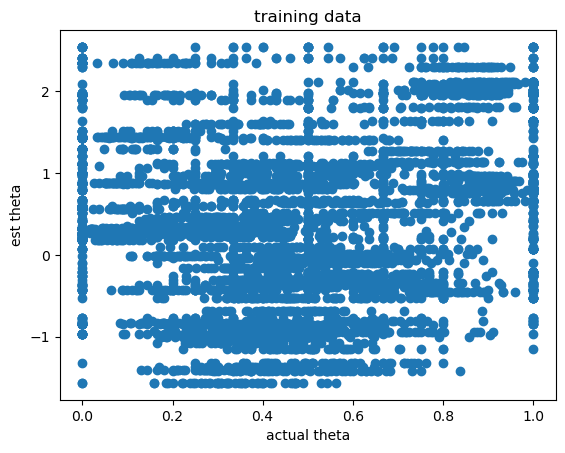

In [17]:
model.eval()
likelihood.eval()

# with torch.no_grad():
#     f_pred = model(train_x)
#     mu = f_pred.mean.numpy()
    
with torch.no_grad():
    f_pred = model(train_x)
    mu = f_pred.mean.cpu().numpy() 
    
if torch.is_tensor(train_theta) and train_theta.is_cuda:
    train_theta = train_theta.cpu().numpy()
elif not isinstance(train_theta, np.ndarray):
    train_theta = train_theta.numpy()


plt.scatter(train_theta,mu/np.std(mu))
plt.xlabel("actual theta")
plt.ylabel("est theta")
plt.title("training data")

Text(0.5, 1.0, 'test data')

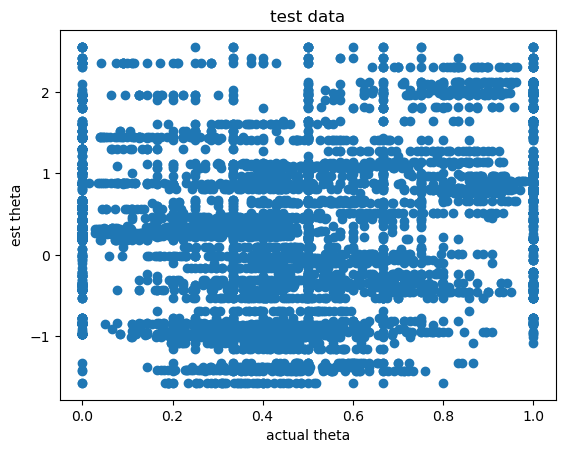

In [20]:
model.eval()
likelihood.eval()

with torch.no_grad():
    f_pred2 = model(test_x)
    mu2 = f_pred2.mean.cpu().numpy()

if torch.is_tensor(test_theta) and test_theta.is_cuda:
    test_theta = test_theta.cpu().numpy()
elif not isinstance(test_theta, np.ndarray):
    test_theta = test_theta.numpy()

plt.scatter(test_theta,mu2/np.std(mu2))
plt.xlabel("actual theta")
plt.ylabel("est theta")
plt.title("test data")

In [22]:
results = pd.DataFrame({"true_theta": train_theta, "est_mean": mu/np.std(mu)})
results['est_std'] = np.sqrt(f_pred.variance.cpu().numpy())/np.std(mu)

lower = results['est_mean'] - 2*results['est_std']
upper = results['est_mean'] + 2*results['est_std']
print("Train avg 95% Coverage: {:.3f}".format(np.mean(np.logical_and(lower<=train_theta, upper>=train_theta))))
print("Train avg RMSE: {:.3f}".format(np.sqrt(np.mean((train_theta-results['est_mean'])**2))))

Train avg 95% Coverage: 0.038
Train avg RMSE: 0.997


In [52]:
results2 = pd.DataFrame({"true_theta": test_theta, "est_mean": mu2/np.std(mu2)})
results2['est_std'] = np.sqrt(f_pred2.variance.cpu().numpy())/np.std(mu2)

lower = results2['est_mean'] - 2*results2['est_std']
upper = results2['est_mean'] + 2*results2['est_std']
print("Test avg 95% Coverage: {:.3f}".format(np.mean(np.logical_and(lower<=test_theta, upper>=test_theta))))
print("Test avg RMSE: {:.3f}".format(np.sqrt(np.mean((test_theta-results2['est_mean'])**2))))


results2["Type"] = "test"
combined_df = pd.concat([results, results2], ignore_index=True)

combined_df.to_csv("GPR_result.csv")

Test avg 95% Coverage: 0.039
Test avg RMSE: 1.001


In [ ]:
!ls /content/drive/My\ Drive/Colab\ Notebooks/Model/

data.csv  Model_running.ipynb  rho.csv	test_data.csv  train_data.csv


In [50]:
# Specify a path for saving
model_path = "/home/alexis/Downloads/superSurvey_model.pth"
optimizer_path = "/home/alexis/Downloads/superSurvey_optimizer.pth"

# Save the model state
torch.save(model.state_dict(), model_path)

# Save the optimizer state
torch.save(optimizer.state_dict(), optimizer_path)